# <center>Искусственный интеллект. Введение в нейронные сети.</center>

<p style="text-align:right;">выполнил: Морозов Е.А.</p>

***


## Постановка задачи.  

Изменить простую нейронную сеть, построенную в ходе практического занятия с помощью фреймворка pytorch. Итоговая нейронная сеть должна решать задачу многоклассовой (не бинарной) классификации. Для чего нужно использовать функцию потерь (loss-function) и функцию активации (activation-function), отличные от применённых в примере.  

Источник данных: keras MNIST dataset  


### Ход работы.  

1. Подключение библиотек, загрузка данных. Первичный анализ задачи и представление об архитектуре сети.  


2. Изменение нейросети, построенной в ходе разбора учебной задачи:
    - увеличение количества скрытых слоев (увеличить с 2 до 3)
    - количество нейронов подставлять через массив, подаваемый при инициализации класса модели
    - добавить *dropout=0.3* (вероятность выпадения нейрона в слое путём зануления его веса) до первого скрытого слоя  


3. Показать, как изменения сети влияют на результат работы модели на тестовой выборке.  


4. Посчитать метрики классификации через *classification report (sklearn)* для каждого класса.  


5. Составление выводов.  

***

## Исследование.  

Рассмотрев в ходе лекции сферы применения нейронных сетей и ознакомившись с устройством простейших моделей нейронных сетей, выясним, как происходит процесс ее обучения и какие гипер-параметры влияют на функционирование нейронной сети.  

Учебный пример был построен на библиотеке **PyTorch**, однако в целях самообразования и сравнения была предпринята попытка ознакомления с библиотекой **Tensorflow** и фреймворка-надстройки над ней - **Keras**, которая приводится в тексте ниже.  

Разбор начальной задачи вылился в увлекательное исследование темы нейронных сетей как универсальных классификаторов, которое будёт продолжено автором в порядке личной инициативы в виду потрясающего потенциала и действительной универсальности последних.  


### Загрузка, импорты. Описание данных. EDA.  

Сделаем импорты, установим компоненты для работы, опишем и проанализируем наблюдаемые данные.

In [1]:
# перенесём импорты в первую ячейку
#!pip install [keras, tensorflow, torch]

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, AvgPool2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score,\
                            accuracy_score, classification_report, confusion_matrix,\
                            ConfusionMatrixDisplay                           
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

### Нейрон. Линейная регрессия.  

В порядке ознакомления с библиотекой и порядком вызова методов создадим сеть из 1 нейрона с помощью методов библиотеки **Keras**.  
* `Sequential` - класс последовательных слоёв сети, используем 1 слой.  
* `Dense` - класс полносвязного слоя, в котором все нейроны текущего слоя связаны со всеми нейронами след. слоя.  
* `units=1` - кол-во нейронов слоя.  
* `input_shape=(1,)` - размер входного слоя.  
* `activation='relu'` - функция активации.  

Для воспроизводимости результатов зафиксируем случайность через метод **tensorflow**.

In [2]:
tf.random.set_seed(606)

In [3]:
# начнём с простой модели из 1 нейрона и выведем резюме по модели
model = Sequential([
    Dense(1, input_shape=(1,), activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


В резюме указаны 2 тренируемых параметра - это веса связей и свободных коэффициентов при них, рассмотрим их детальнее.

In [4]:
# получим первоначальные веса при инициализации и сравним c результатами предсказаний
# линейной функции активации по 1 объекту тренировочной выборки
w1, w0 = model.get_weights()
w1, w0

(array([[0.38008606]], dtype=float32), array([0.], dtype=float32))

In [5]:
X = np.array([1,3,10,17,-67])
model.predict(X[:1])

1/1 [==============================] - 0s 62ms/step


array([[0.38008606]], dtype=float32)

In [6]:
w1*X[:1]+w0 

array([[0.38008606]])

In [7]:
from keras.activations import linear
linear(w1*X[:1]+w0)

array([[0.38008606]])

### Нейрон умножения на число.  

Повторим создание сети из 1 нейрона для операции умножения на число, создадим обучающий набор данных с которым будем работать.

In [8]:
rng = np.random.RandomState(seed=606)

# данные для обучения
X = np.array([[x] for x in rng.randint(-100, 100, 20)])
y = np.array([x*7.5 for x in X])

X, y

(array([[ 33],
        [ 34],
        [ 69],
        [-12],
        [ 56],
        [-35],
        [ 93],
        [ 40],
        [-97],
        [ 71],
        [ 32],
        [ 22],
        [-59],
        [-67],
        [ 28],
        [ -8],
        [-97],
        [ -3],
        [ 56],
        [-88]]),
 array([[ 247.5],
        [ 255. ],
        [ 517.5],
        [ -90. ],
        [ 420. ],
        [-262.5],
        [ 697.5],
        [ 300. ],
        [-727.5],
        [ 532.5],
        [ 240. ],
        [ 165. ],
        [-442.5],
        [-502.5],
        [ 210. ],
        [ -60. ],
        [-727.5],
        [ -22.5],
        [ 420. ],
        [-660. ]]))

In [9]:
# при таком диапазоне входных значений решение сети скорее всего не будет сходиться,
# нормируем значения Х

scaler = MinMaxScaler()
X_norm = scaler.fit(X).transform(X)
X_norm, y

(array([[0.68421053],
        [0.68947368],
        [0.87368421],
        [0.44736842],
        [0.80526316],
        [0.32631579],
        [1.        ],
        [0.72105263],
        [0.        ],
        [0.88421053],
        [0.67894737],
        [0.62631579],
        [0.2       ],
        [0.15789474],
        [0.65789474],
        [0.46842105],
        [0.        ],
        [0.49473684],
        [0.80526316],
        [0.04736842]]),
 array([[ 247.5],
        [ 255. ],
        [ 517.5],
        [ -90. ],
        [ 420. ],
        [-262.5],
        [ 697.5],
        [ 300. ],
        [-727.5],
        [ 532.5],
        [ 240. ],
        [ 165. ],
        [-442.5],
        [-502.5],
        [ 210. ],
        [ -60. ],
        [-727.5],
        [ -22.5],
        [ 420. ],
        [-660. ]]))

* архитектура сети останется прежней, состоящей из 1 нейрона, на вход которому подаются значения, проходят через линейную функцию активации и на выход приходят также по 1 значению без преобразований.    
* активация в данном случае линейная, чтобы изменять значение входа **линейно**, а не иначе.   
* оптимизации будет подвергаться значение *MSE*.  
* метрикой качества будем считать *MAE*.

Линейная активация подходит, поскольку не меняет значения входа. Метод оптимизации, функция потерь и метрика качества задаются в атрибутах метода `compile()`.

In [10]:
%%time

# скомпилируем модель с пом. стохастич. градиентного спуска
# и указанных выше функции потерь и метрики качества
model = Sequential([
    Dense(1, input_shape=(1,), activation='linear')
])

model.compile(optimizer='sgd', loss='mse', metrics='mae')

# обучим модель на 100 эпохах для нахождения весов

model.fit(X_norm, y, epochs=6000, verbose=0)

Wall time: 14.5 s


In [11]:
# проверим обобщающую способность
X_test = [[-1000], [(1+1/3)*100]]
print('вход:', *X_test)
print('предсказания (х*7.5):', *model.predict(scaler.transform(X_test), verbose=0))

вход: [-1000] [133.33333333333331]
предсказания (х*7.5): [-7498.489] [999.81635]


Модель работает достаточно сносно, хотя обучение и происходит гораздо медленнее линейной регрессии, тем не менее такова обобщающая способность лищь 1 нейрона с линейной функцией активации! Усложним сеть и используем её для нахождения суммы нескольких чисел (или других арифм. действий).

### Нейронная сеть для арифметических действий.  

Как стало понятно из примера выше, для улучшения обобщающей способности и увеличения скорости обучения, сеть можно несколько усложнить добавлением как нейронов в слоях так и добавлением непосредственно скрытых слоёв.  

Проверим такое предположение на примере сети, изображенной ниже. Также будем учитывать, что последовательное соединение слоёв с линейной функцией активации равносильно линейной регрессии и можно подобное расширение "оптимизировать", избавившись от лишних слоёв.  

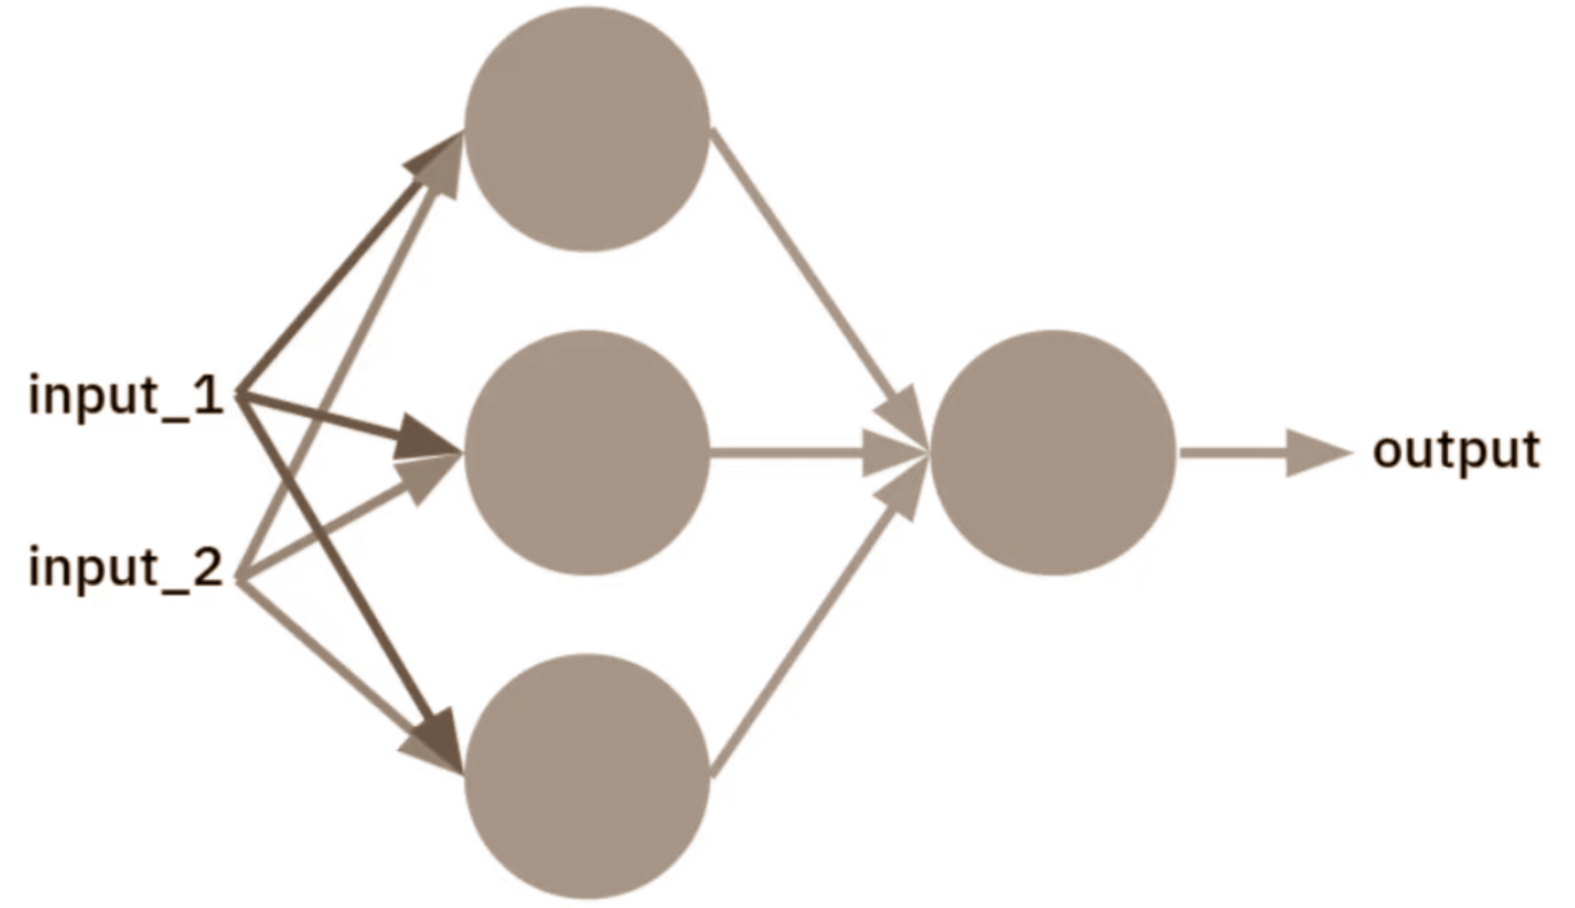

In [12]:
# данные для обучения
X1 = np.array([[x] for x in rng.randint(-100, 100, 50)])
X2 = np.array([[x] for x in rng.randint(-100, 100, 50)])
X = np.hstack([X1,X2])

y = np.array([x[0]+(x[1]*2) for x in X]).reshape(-1,1)#.ravel()

# смасштабируем значения для сходимости решения сети
X_norm = scaler.fit(X).transform(X)

print('X_non_scaled:\n', X[:5], '\n\nX_scaled:\n', X_norm[:5], '\n\ny:', y[:5])

X_non_scaled:
 [[-41 -79]
 [-35  -7]
 [-30  64]
 [-50 -47]
 [ 94  39]] 

X_scaled:
 [[0.2513369  0.0984456 ]
 [0.28342246 0.47150259]
 [0.31016043 0.83937824]
 [0.20320856 0.2642487 ]
 [0.97326203 0.70984456]] 

y: [[-199]
 [ -49]
 [  98]
 [-144]
 [ 172]]


In [13]:
# Скомпилируем модель с 1 скрытым слоем и обучим на выборке

model = Sequential([
    Dense(input_shape=(2,), units=3, activation='linear'),
    Dense(units=1, activation='linear')   # можно не указывать input_shape
])

# выберем алгоритм Adam в качестве оптимизатора, т.к. sgd с настройками по умолчанию
# часто не сходился на тренир. данных, а настраивать его пока не хотелось

model.compile(optimizer='adam', loss='mse', metrics='mae')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 9         
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
# обучаемся
model.fit(X_norm, y, epochs=7500, verbose=0, shuffle=True)

Wall time: 24.9 s


In [15]:
# делаем проверку
X_test = np.array([[9800, 100]])
print('вход:', *X_test)
print('предсказания (х[0]+2*x[1]):', *model.predict(scaler.transform(X_test), verbose=0))

вход: [9800  100]
предсказания (х[0]+2*x[1]): [10000.226]


- Нейросеть с 1 скрытым полносвязным слоем достигла приемлемой обобщающей способности за 7500 эпох,

- Рассмотрим вариант с большим кол-вом нейронов для улучшения способности к выделению закономерностей. Функции активации оставим всё также линейными т.к. предполагается поиск именно линейных закономерностей, а вот кол-во скрытых слоёв увеличивать не станем именно по этой причине.

In [16]:
%%time

model = Sequential([
    Dense(input_shape=(2,), units=20, activation='linear'),
    Dense(units=1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics='mae')

model.fit(X_norm, y, epochs=3000, verbose=0)

Wall time: 10.7 s


In [17]:
print('предсказания (х[0]+2*x[1]):', *model.predict(scaler.transform(X_test), verbose=0))

предсказания (х[0]+2*x[1]): [10027.452]


- При фиксированном количестве примеров (небольшом) нейронную сеть можно обучить либо на более простой архитектуре за большее количество эпох, либо на более разветвлённой, но за меньшее время. Здесь нужно искать компромисс, поскольку более сложная сеть может наоборот начать "обучаться" слишком медленно.  


### Полносвязная сеть для нелинейной зависимости.  

Рассмотрим также способности полносвязной сети выявлять более сложные и нелинейные закономерности в данных. Создадим сеть более сложной архитерктуры с различными функциями активации (нелинейными чтобы воспроизводить нелинейные зависимости), увеличив количество как обучающих примеров так и эпох, поскольку при "недостатке" того или иного параметра восстановить зависимости с приемлемой точностью у сети навряд ли получится.  

Полезным и интересным опытом будет работа с батчевой обработкой примеров - `batch_size`, обратными вызовами библиотеки - `callbacks` и генераторами из соотв. разделов библиотеки. 

In [18]:
%%time

# данные для обучения
X1 = np.array([[x] for x in rng.randint(-1000, 1000, 500)])
X2 = np.array([[x] for x in rng.randint(-1000, 1000, 500)])
X = np.hstack([X1,X2])

y = np.array([(x[0]-123)+(x[1]**3) for x in X]).reshape(-1,1)#.T.ravel()

# смасштабируем значения для сходимости решения
X_norm = scaler.fit(X).transform(X)
y_norm = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0)) # "y" мы также масштабируем для сходимости

## для использования кастомных функций активации импортируем ориг.функц-ии из backend
## изменим функцию relu для имеющегося примера
def alt_relu(x):
    return K.relu(x, alpha=0.1)

# создадим новую модель с несколькими скрытыми слоями с разной активацией
model = Sequential([
    Dense(units=50, activation=alt_relu),
    Dense(units=50, activation=alt_relu), ## кастомная функц.активации
    #Dense(units=100, activation='elu'),
    Dense(units=50, activation='sigmoid'),
    Dense(units=1, input_dim=50, activation='linear')
])

## для настройки оптимизатора импортируем соотв. обект
adam = Adam(learning_rate=0.1)                               ## создаём оптимизатор

model.compile(optimizer=adam, loss='mse', metrics='mae')   ## указываем оптимизатор

## для настройки обратных вызовов импортируем соотв. обект
## EarlyStopping позволяет выйти из обучения при достижении лучших результатов до конца
## обучения и использовать модель с лучшим резуьтатом
early_stopping = EarlyStopping(
    monitor="mae",   ## монитор отслеживающий метрику 
    min_delta=0.0001,
    patience=100,   ## задержка перед выходом из обучения по лучшему результату
    verbose=1,
    mode="auto",     ## режим монитора (loss - должен падать, метрика - улучшаться)
    baseline=None,
    restore_best_weights=True,   ## модель должна восстанавливаться с лучшими весами
    start_from_epoch=0
)

## ReduceLROnPlateau позволяет уменьшать learning_rate при падении роста качества чтобы
## скатываться в зоны оптимума поблизости на меньшем learning_rate
reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

model.fit(X_norm, y_norm,
            epochs=300,
            #batch_size=64,
            steps_per_epoch=10,
            callbacks=[early_stopping, reduce_lr],   ## передаём callback в списке
            verbose=0,
            shuffle=True)


Epoch 33: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.012500000186264515.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0062500000931322575.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0031250000465661287.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0015625000232830644.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0007812500116415322.

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0003906250058207661.

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.00019531250291038305.

Epoch 94: ReduceLROnPlateau reducing learning rate to 9.765625145519152e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 4.882812572759576e-05.

Epoch 106: ReduceLROnPlateau reducing learning rate to 2.441406286379788e-05.

Epoch 112: ReduceLROnPlateau reducing learning rate to 1.22070314

In [19]:
# сравним предсказание модели с ground_truth
X_test = np.array([[9800, 100]])

print('Cравним предсказания модели с истынм значением.')
print('Тестовые данные:', (X_test[0][0], X_test[0][1]))
print('Предсказание модели =', *model.predict(scaler.transform(X_test), verbose=0))
print('Истина (также смасштабированная) ='
      , (((X_test[0][0]-123)+(X_test[0][1]**3)) - y.min()) / (y.max() - y.min()))

model.summary()

Cравним предсказания модели с истынм значением.
Тестовые данные: (9800, 100)
Предсказание модели = [0.48313588]
Истина (также смасштабированная) = 0.4944828326005991
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                150       
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


- Пример был взят не самый простой и удачный (**у** зависит от 2 параметров), поэтому результат долгое время получался также не лучший, но ошибку удалось значительно снизить при нормализации всех данных. С усложнениями архиектуры сети, привлечением методов деления выборки на батчи, обратных вызовов и др. манипуляций некоторый прогресс в работе над задачей был достигнут. Дальнейшие улучшения явно возможны, но в рамках учебной работы выполняться они не будут для сохранения возможности более комплексного исследования других тем.


- Поскольку общеизвестных эффективных архитектур нейросетей для табличных и НЕ избыточных данных не существует, то для достаточно качественного обучения приходится проводить длительный этап обучения сети. Если закономерность не предполагается понятной заранее, то этот процесс характеризуется различной степенью усложнения сети: усложнения структуры, увеличения числа примеров и эпох обучения.  


- Здесь вполне успешную конкуренцию нейро-сетевому подходу составляют классические ML-алгоритмы, при чём они скорее всего будут более эффективными. Однако именно широкая обобщающая способность нейронных сетей вызывает интерес для изучения.  


## Классификация изображений нейронной сетью глубокого обучения.  

Далее в небольшом приближении разберём возможности нейронных сетей при работе с изображениями на примерах наборов данных, встроенных в библиотеку `keras`.  

Возможности сверточных слоёв, обучения на граф. ускорителях и др. приёмы и специфические архитектуры подробно не рассматривались и пока находятся за рамками исследования. В конечном счёте выполним пункты задания, завершив таким образом исследование.  


### Подготовка набора данных.  

Загрузим набор данных MNIST , рассмотрим разметку объектов и подготовим изображения для облечения обучаемости сети.

In [20]:
# загрузим датасет из модуля библиотеки

from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [21]:
# размеры изображения
X_train[0].shape

(28, 28)

Пример размеченных изображений из датасета:


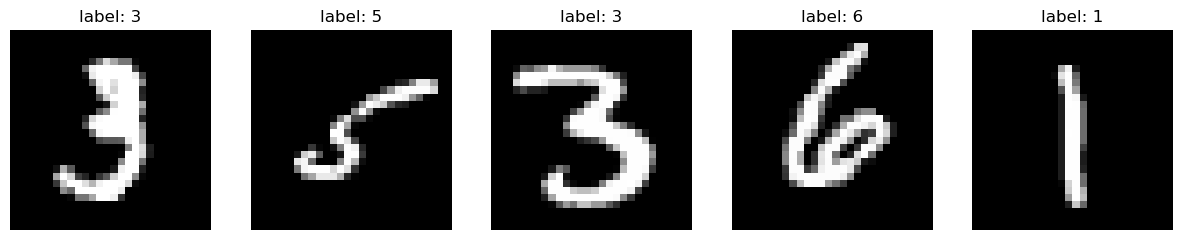

In [22]:
print('Пример размеченных изображений из датасета:')
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for i in range(5):
    ax[i].imshow(X_train[i+10], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'label: {y_train[i+10]}')

In [23]:
# для упрощения сократим набор данных (для обуч. и тестовой выборки)
idxs_2cl = np.where((y_train==0)|(y_train==1))
y_train = y_train[idxs_2cl]
X_train = X_train[idxs_2cl]
X_train.shape, y_train.shape

((12665, 28, 28), (12665,))

In [24]:
# для упрощения сократим набор данных (для обуч. и тестовой выборки)
idxs_2cl = np.where((y_test==0)|(y_test==1))
y_test = y_test[idxs_2cl]
X_test = X_test[idxs_2cl]
X_test.shape, y_test.shape

((2115, 28, 28), (2115,))

Пример изображений выбранных классов (0 и 1) из датасета:


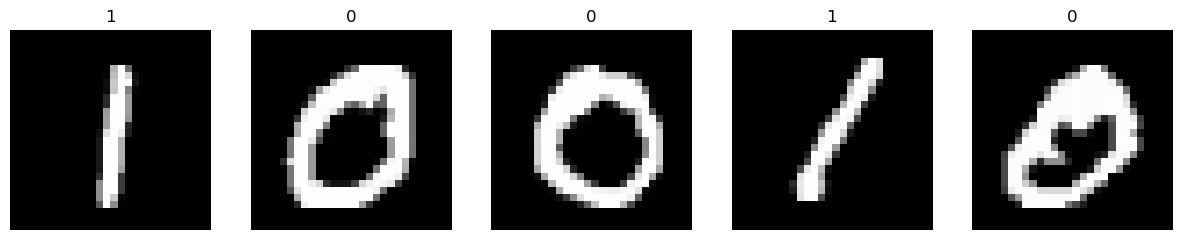

In [25]:
print('Пример изображений выбранных классов (0 и 1) из датасета:')
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for i in range(5):
    ax[i].imshow(X_train[i+10], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(y_train[i+10])

- Как говорилось выше данные надлежит нормировать, но в случае изображений сделаем это без `MinMaxScaler`, воспользуемся делением на 255, т.к. изображения представлены пикселями со значением яркости в диапазоне от 0 до 255. В итоге нейросеть будет обучаться на значениях в диапазоне от 0 до 1.

In [26]:
# нормируем значения яркости на 255
X_train = X_train/255
X_test = X_test/255

- В обуч. материалах предлагается видоизменять метки класса с помощью прямого кодирования. Значения 0 или 1, можно преобразовать в бинарный вид. Тем самым получаем 2 столбика, где первый - это метка является ли изображение 0 классом, а второй столбик - является ли изображение 1 классом.

In [27]:
# преобразуем метки классов методами библиотеки keras (без OHE из sklearn)
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

y_train[:5], y_train_cat[:5]

(array([0, 1, 1, 1, 1], dtype=uint8),
 array([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32))

- Также поменяем разрешение изображений из набора данных, уменьшив их с 28х28, до 6х6, чтобы быстрее обучать нейросеть.

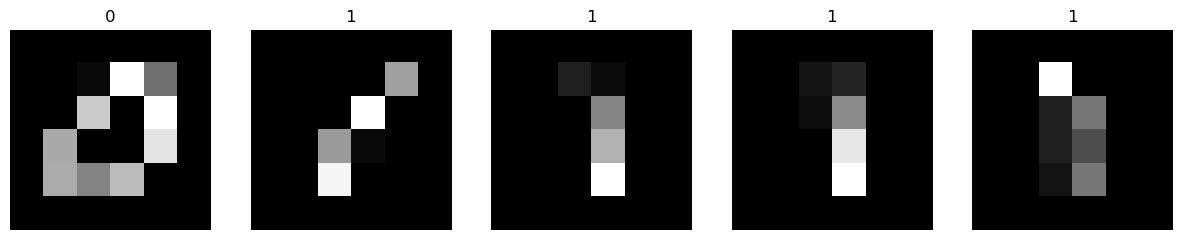

In [28]:
# сожмём изображения и проверим результаты

## X_train[..., np.newaxis] - создаёт фиктивный канал в тензоре изображения
## чтобы корректно сжать его до 6*6
## "...[..., 0]" сбрасывает канал делая тензор прежней размерности

X_train_resized = tf.image.resize(X_train[..., np.newaxis], (6, 6))[..., 0]
X_test_resized = tf.image.resize(X_test[..., np.newaxis], (6, 6))[..., 0]

fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train_resized[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(y_train[i])

### Модели бинарной классификаций изображений (нейросетевые + ML-baseline).  

Подготовив таким образом изображения, приступим к обучению сети. Построим архитектуру сети, выберем оптимизатор, функцию активации и функцию потерь, настроим кол-во эпох обучения:  

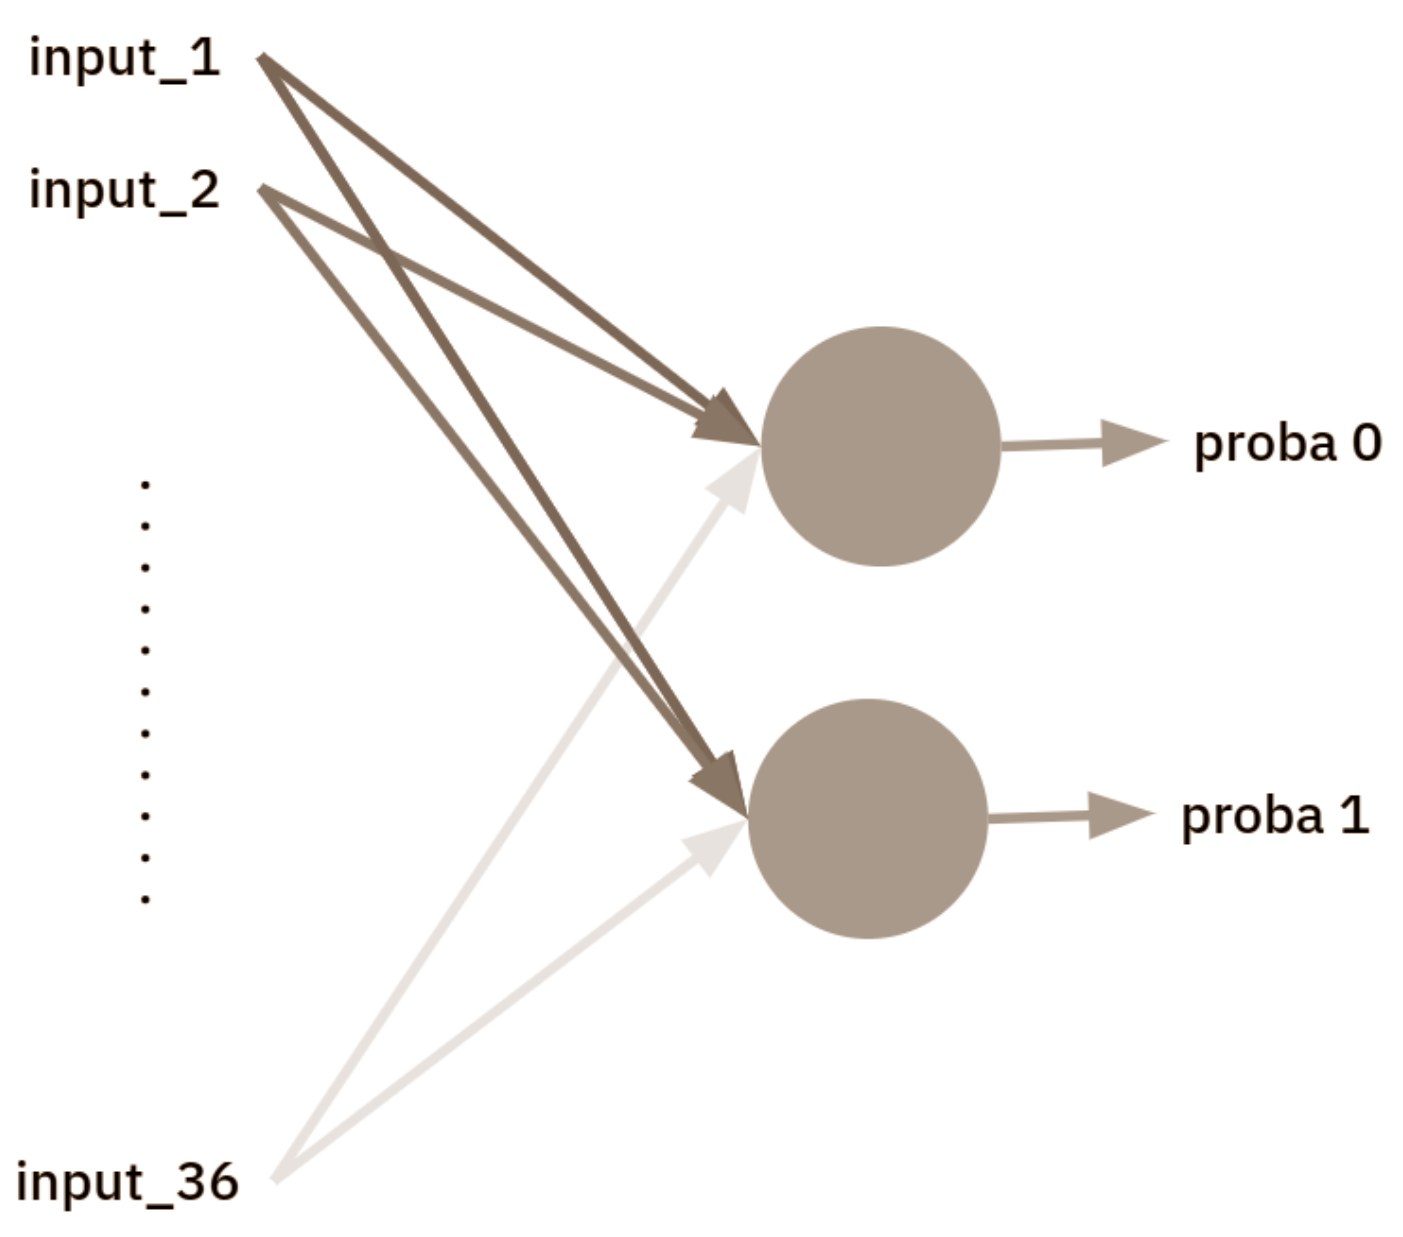

   1. На вход будут подаваться изображения 6х6, которые нужно разложить в вектор (1,36) (пока работать с двумерным входом мы не станем). Этого можно достичь, добавив слой `Flatten` в объект `Sequential`, который вытягивает изображение в один вектор.

   2. Выходов из сети должно быть 2. Т.е. 2 нейрона, отображающих две вероятности: быть или не быть определенным классом.  
    
   3. На выходном слое используем функцию активации **sigmoid**, поскольку стоит задача бинарной классификации.  
    
   4. Для задачи бинарной классификации функция потерь также будет отличной от **MSE**, в данном примере подходит бинарная кросс-энтропия.  
    
   5. В качестве метрики качества классификации возьмём более понятную для восприятия **accuracy**.

In [29]:
# сконструируем и скомпилируем сеть
model = Sequential([
    Flatten(input_shape=(6, 6)),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

# выведем информацию по сети
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 74        
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


Количество весов для нахождения градиентным спуском = для каждого (из двух) нейрона - 36 входов, плюс 1 свободный вес = (36 + 1) * 2 = 74.

In [30]:
%%time
# обучим скомпилированную нейросеть с указанием тестовой выборки, 
# чтобы сразу иметь возможность видеть процесс обучения без послед. проверки на тесте,
# укажем кол-во батчей/шагов за эпоху, а также выбранные callback-и

## задаем новый EarlyStopping
early_stopping_pic = EarlyStopping(
    monitor="val_loss",   ## монитор, отслеживающий метрику на валидации 
    min_delta=0.001,
    patience=10,     ## задержка перед выходом из обучения по лучшему результату
    verbose=1,
    mode="auto",     ## режим монитора (loss - должен падать, метрика - улучшаться)
    baseline=None,
    restore_best_weights=True,   ## модель должна восстанавливаться с лучшими весами
    start_from_epoch=0,
)

## задаем новый ReduceLROnPlateau
reduce_lr_pic = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

model.fit(X_train_resized, y_train_cat,
          validation_data=(X_test_resized, y_test_cat),
          epochs=100,
          #batch_size=64,
          steps_per_epoch=100,
          callbacks=[early_stopping_pic, reduce_lr_pic],     ## передаём callback
          shuffle=True,
          verbose=0)

Wall time: 18.3 s


На выходе модель выдаёт 2 вероятности: быть нулевым или первым классом - какая из них больше, тот класс объекту и будет присваиваться. В данном случае классы совпадают с метками объектов. Проверим результаты обучения модели как на конкретном примере изображения, так и на всей тестовой выборке.

1/1 [==============================] - 0s 38ms/step
Предсказание нейронной сети на объекте №10:  [0.00784873 0.9913934 ]
Таким образом предсказанный класс объекта №10: 1
Рассмотрим непосредственно избражения, соотв. объекту №10.


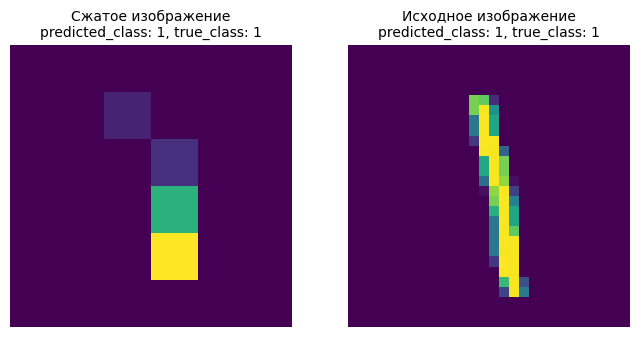

In [31]:
pred = model.predict(X_test_resized[9:10])
print("Предсказание нейронной сети на объекте №10: ", *pred)

pred_cls = pred.argmax()
print("Таким образом предсказанный класс объекта №10:", pred_cls)

print("Рассмотрим непосредственно избражения, соотв. объекту №10.")
idx = 9
fig, ax = plt.subplots(1, 2, figsize=(8,10))
ax[0].imshow(X_test_resized[idx])
ax[0].axis('off')
ax[0].set_title(
    f'Сжатое изображение\npredicted_class: {pred_cls}, true_class: {y_test[idx]}'
    , fontsize=10
)

ax[1].imshow(X_test[idx])
ax[1].axis('off')
ax[1].set_title(
    f'Исходное изображение\npredicted_class: {pred_cls}, true_class: {y_test[idx]}'
    , fontsize=10
)
plt.show()

67/67 [==============================] - 0s 770us/step

Матрица ошибок классификации (на тестовой выборке) с порогом 0,5:


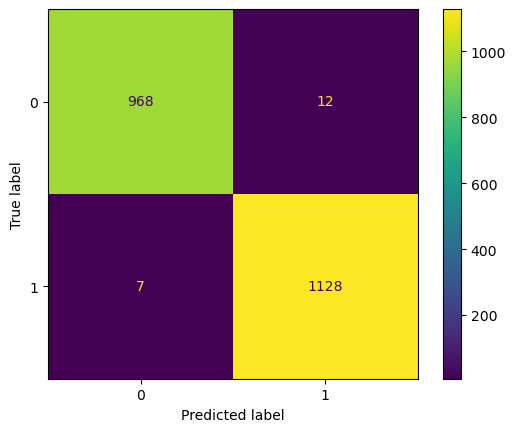

In [32]:
## выведем матрицу ошибок классификации (отчёт выведем в итоговом примере)

# classification_report
y_true = y_test
y_pred = model.predict(X_test_resized)[:,1] > 0.5   # можно было через np.where() сделать

# матрица ошибок
print('\nМатрица ошибок классификации (на тестовой выборке) с порогом 0,5:')
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()                             
plt.show()

In [33]:
# отчёт классификации

print('Отчёт классификации:')
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
pd.DataFrame(report).round(4).transpose()

Отчёт классификации:


,precision,recall,f1-score,support
0,0.9928,0.9878,0.9903,980.000
1,0.9895,0.9938,0.9916,1135.000
accuracy,0.9910,0.9910,0.9910,0.991
macro avg,0.9911,0.9908,0.9910,2115.000
weighted avg,0.9910,0.9910,0.9910,2115.000


* Задача классификации изображений на 2 класса была решена довольно успешно. В результате этапов предобработки и подготовки данных сеть обучилась быстро.  


#### Baseline on SKLearn LogisticRegression.  

Любопытно будет обратиться к результатам классификации, построенной на алгоритме логистической регрессии из библиотеки `sklearn` как к некоему **baseline** для сравнения и оценки эффективности работы алгоритмов. Её использование вполне уместно, поскольку количество объектов обучающей выборке не слишком огромно и при использовании сжатых изображений кол-во признаков также не будет вызывать тревогу за возможность обучить модель.

In [34]:
%%time
# создадим из наборов уменьшенных изображений набор данных для обучения логистич.регресси

train_data = pd.DataFrame(data=np.reshape(X_train_resized,(len(X_train_resized),-1,1))[...,0])
test_data = pd.DataFrame(data=np.reshape(X_test_resized,(len(X_test_resized),-1,1))[...,0])
print('Нормировнные значения яркости пикселей изображения в качестве признаков для обучения:')
display(train_data.sample(3))

# выбираем индексы объектов, отн. к классам 1 и 0
train_idxs_2cl = np.where((y_train==0)|(y_train==1))
test_idxs_2cl = np.where((y_test==0)|(y_test==1))

# по полученным индексам строим соотв. наборы признаков (обучение и тест) 
y_train_2cl = y_train[train_idxs_2cl]
X_train_2cl = train_data.iloc[train_idxs_2cl]

y_test_2cl = y_test[test_idxs_2cl]
X_test_2cl = test_data.iloc[test_idxs_2cl]

print('Размеры выборок для обученичения:')
print(*(X_train_2cl.shape, y_train_2cl.shape), (X_test_2cl.shape, y_test_2cl.shape), '\n')

# инициализация модели
model_LR = LogisticRegression(random_state=606)

# обучение модели с кросс-валидацией с подбором гиперпараметров по сетке (неподробно, близко к дефолтным)

## Pipeline с предобработкой не требуется, значения яркости уже нормированы
## выполним поиск лучших гиперпарметров по сетке с кросс-валидацией

grid = {
    'penalty': ['l2'], #['l1', 'l2'],
    'C': np.linspace(20, 40, 20), #[*np.linspace(0.0001, 1, 50), *np.linspace(10, 100000, 50)],
    'max_iter': [5000],
    'class_weight': ['balanced'],
    'solver': ['saga']
}

LR_clf = RandomizedSearchCV(
    model_LR,
    param_distributions=grid,
    random_state=606,
    n_iter=20,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    cv=4
)

LR_clf.fit(X_train_2cl, y_train_2cl)

# выведем результаты на экран:
print('\nЛогистическая регрессия\n')
print('- Лучший accuracy_score = ', LR_clf.best_score_.round(5))
print('- Лучшие параметры:\n\t', {str(i):LR_clf.best_params_.get(i) for i in LR_clf.best_params_})
print('- Лучшая модель:\n\t доступна из "LR_clf.best_estimator_"\n')

Нормировнные значения яркости пикселей изображения в качестве признаков для обучения:


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.115687,...,0.043791,0.115687,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.584640,...,0.974510,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103922,0.992157,0.863726,...,0.992157,0.992157,0.415686,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Размеры выборок для обученичения:
(12665, 36) (12665,) ((2115, 36), (2115,)) 

Fitting 4 folds for each of 20 candidates, totalling 80 fits

Логистическая регрессия

- Лучший accuracy_score =  0.99029
- Лучшие параметры:
	 {'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 25.263157894736842}
- Лучшая модель:
	 доступна из "LR_clf.best_estimator_"

Wall time: 52.3 s


In [35]:
# отчёт классификации
print('Отчёт классификации:')
report = classification_report(
                                y_test_2cl
                                , LR_clf.best_estimator_.predict(X_test_2cl)
                                , digits=4, output_dict=True
)

pd.DataFrame(report).round(4).transpose()

Отчёт классификации:


,precision,recall,f1-score,support
0,0.9878,0.9898,0.9888,980.0000
1,0.9912,0.9894,0.9903,1135.0000
accuracy,0.9896,0.9896,0.9896,0.9896
macro avg,0.9895,0.9896,0.9895,2115.0000
weighted avg,0.9896,0.9896,0.9896,2115.0000


* Логистическая регрессия даже без подбора гиперпараметров на двухклассовой классификации довольно быстро достигает эффективности приведённой выше нейросети, вплотную приближаясь к ней, регуляризация помогает ещё несколько сблизить значения метрик на тестовой выборке. Учитывая скорость, с которй обучется логистическая регрессия, могут рождаться вопросы в отношении целесообразности использования перцептрона НЕспециализированной архитектуры для предсказаний, но выбор в любом случае останется за исследователем.  

### Модели мультиклассовой классификации изображений (10 классов, нейросетевые + ML-baseline).  

Расширим область действия, измененив модель, построенную выше в целях решения следующих задач:  

- увеличение количества скрытых слоев,  
- количество нейронов подставлять через массив, подаваемый при инициализации класса модели (не совсем понятен смысл этого действия, выполнять его в данном решении не стал, как это сделать в целом ясно),  
- добавить dropout=0.3 до первого скрытого слоя (вероятность выпадения нейрона в слое, путём зануления его веса). В целом этот приём может как оказать полезный эфект на обобщающую способноть модели за счёт более равномерного распределения весов, так и ничего принципиально не изменить, что можно буде понять на практике. Для реализации в библиотеке предусмотрен соотв. объект слоя.
- Показать, как изменения сети влияют на результат работы модели на тестовой выборке. В данном пункте удобнее всего будет указать на необходимость разбиения выборки на 2 части в атрибуте `validation_split` метода `fit()` и отслеживать изменение функции потерь и метрики на тренировочной и тестовой выборках по выводимому логу.    
- Посчитать метрики классификации через `classification report` (sklearn) для каждого класса.

1. Загрузим датасет, оценим размеры выборок.

X_train.shape: (60000, 28, 28)  X_test.shape: (10000, 28, 28)

Пример размеченных изображений из датасета:


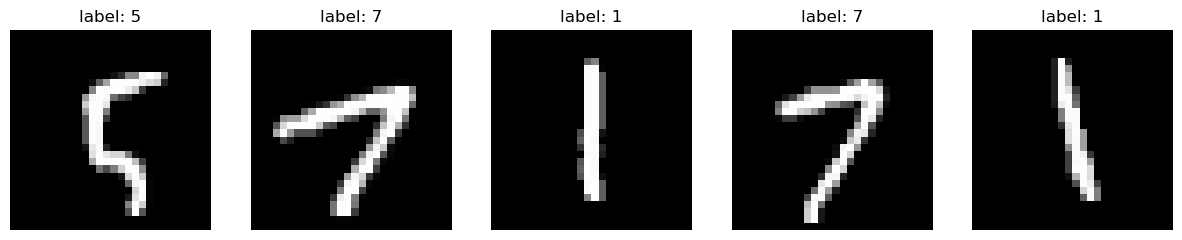


2. Нормируем значения пикселей и перекодируем метки целевого класса.

Метка класса до кодирования: [5 0 4 1 9] 
Метки калссов в результате кодирования:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

3. Сожмём размеры изобаражений для ускорения процесса обучения.

Пример изображений из датасета после сжатия:


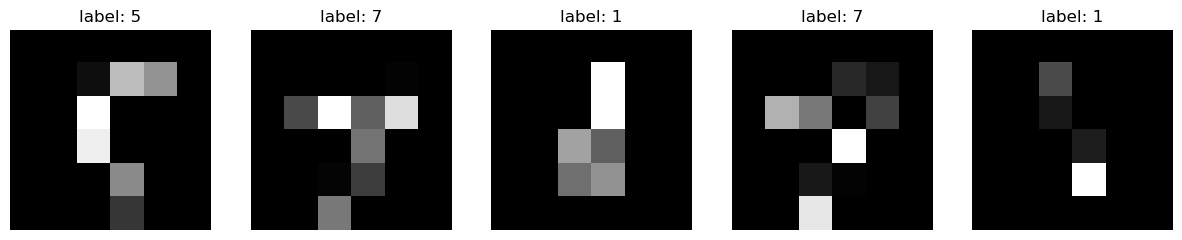

In [36]:
# повторно загрузим датасет с изображениями всех классов
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('1. Загрузим датасет, оценим размеры выборок.')
print('\nX_train.shape:', X_train.shape, ' X_test.shape:', X_test.shape)

print('\nПример размеченных изображений из датасета:')
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for i in range(5):
    ax[i].imshow(X_train[i+100], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'label: {y_train[i+100]}')
plt.show()

# нормируем значения яркости на 255
X_train = X_train/255
X_test = X_test/255

# преобразуем метки классов методами библиотеки keras
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print('\n2. Нормируем значения пикселей и перекодируем метки целевого класса.')
print('\nМетка класса до кодирования:', y_train[:5],
      '\nМетки калссов в результате кодирования:\n', y_train_cat[:5])

# сожмём изображения и проверим результаты
print('\n3. Сожмём размеры изобаражений для ускорения процесса обучения.')

## X_train[..., np.newaxis] - создаёт фиктивный канал в тензоре изображения
## чтобы корректно сжать его до 6*6
## "...[..., 0]" сбрасывает канал делая тензор прежней размерности

X_train_resized = tf.image.resize(X_train[..., np.newaxis], (6, 6))[..., 0]
X_test_resized = tf.image.resize(X_test[..., np.newaxis], (6, 6))[..., 0]

fig, ax = plt.subplots(1, 5, figsize=(15, 10))

print('\nПример изображений из датасета после сжатия:')
for i in range(5):
    ax[i].imshow(X_train_resized[i+100], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'label: {y_train[i+100]}')
plt.show()

Для человеческого восприятия сжатие кажется весьма агрессивным и по таким изображениям метки классов расставить крайне затруднительно, тем интереснее будет увидет насколько успешнее нейросеть может оказаться в решении такой специализированной задачи. Обучающая и тестовая выборки сформированы, перейдём к конструированию сети.  

#### Нейросеть глубокого обучения (1 слой + dropout) для предобработанных входных данных.

Попробуем начать с простого размышления — для разделения требуется логистическая регрессии, но с десятью классами. Т.е. разделение будет осуществляться в выходном слое с помощью функции активации, отличной от **sigmoid**, в нашем случае нужно использовать фукнкцию **softmax**.  

Функция потерь также будет отличаться от **бинарной кросс-энтропии**, речь пойдёт о **разрежённой категориальной кросс-энтропии** или **sparse_categorical_crossentropy** ("sparse" говорит о способе кодирования ответов), если в задаче требуется просто номер класса, то используем эту функцию потерь. В нашем случае, когда ответы кодируются One-Hot-Encoding и, например, классу 9 соответствует целый вектор [0, 0, 0, 0, 0, 0, 0, 0, 1], тогда применим `categorical_crossentropy()`.

In [37]:
# сконструируем и скомпилируем сеть для новой задачи:

## 10 классов на выходе, как минимум 1 скрытый слой, dropout=0.3 на первом слое,
## sigmoid в многоклассовой классификации заменяется на функцию softmax, зависящую
## от большего количества входов

tf.random.set_seed(606)

model = Sequential([
    Flatten(input_shape=(X_train_resized[rng.randint(len(X_train_resized))].shape)),
    Dense(units=200, activation='elu'),
    Dropout(.3),# input_shape=(50,)),
    #Dense(units=100, activation='leaky_relu'),
    #Dense(units=10, activation='tanh'),
    Dense(10, activation='softmax')   ## sigmoid заменяется на функцию softmax
])

## зададим learning_rate оптимизатора, отличный от стандартного, для более быстрого обучения
adam = Adam(learning_rate=0.5)

## для 10 классов используем категориальную кросс-энтропию
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics='accuracy')

# выведем информацию по сети
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 36)                0         
                                                                 
 dense_11 (Dense)            (None, 200)               7400      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 10)                2010      
                                                                 
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________


In [38]:
%%time
# обучим скомпилированную нейросеть с указанием тестовой выборки 
# чтобы сразу видеть процесс обучения без послед. проверки на тесте
# укажем кол-во батчей на обработку

## снова задаем EarlyStopping
early_stopping_pic = EarlyStopping(
    monitor="val_loss",   ## монитор, отслеживающий метрику на валидации 
    min_delta=0.0001,
    patience=100,     ## задержка перед выходом из обучения по лучшему результату
    verbose=1,
    mode="auto",      ## режим монитора (loss - должен падать, метрика - улучшаться)
    baseline=None,
    restore_best_weights=True,   ## модель должна восстанавливаться с лучшими весами
    start_from_epoch=0,
)

## снова задаем  ReduceLROnPlateau
reduce_lr_pic = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=2,
    min_lr=1e-8
)

model.fit(X_train_resized, y_train_cat,
            validation_data=(X_test_resized, y_test_cat),
            epochs=100,
            #batch_size=64,         ## выборка помещается в ОЗУ, но разбиение стоит увеличить
            steps_per_epoch=1000,   ## тем или иным способом для улучшения обучаемости модели
            callbacks=[early_stopping_pic, reduce_lr_pic],    ## передаём callback
            shuffle=True,
            verbose=0)


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.25.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.125.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0625.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.03125.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.015625.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0078125.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.00390625.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.001953125.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0009765625.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.00048828125.
Wall time: 3min 40s


* Довольно простая нейросетевая логистическая регрессия на 10 классов научилась достигать точности порядка 0.85 (в зависимости от числа нейронов от 50 до 300 и более). Это не слишком много, но стоит отметить, что обучалась сеть относительно недолго и на батчах из очень маленьких изображений, без свёртончых слоёв перед входом и имея след. особенности устройства.


* Варьирование кол-вом нейронов и dropout-ом на качестве результатов сказывается двояко: сеть может переобучается, либо не приобретать достаточной обобщающей способности из-за малого кол-ва элементов - таким образом приходится искать компромисс.

313/313 [==============================] - 0s 801us/step

Матрица ошибок классификации (на тестовой выборке):


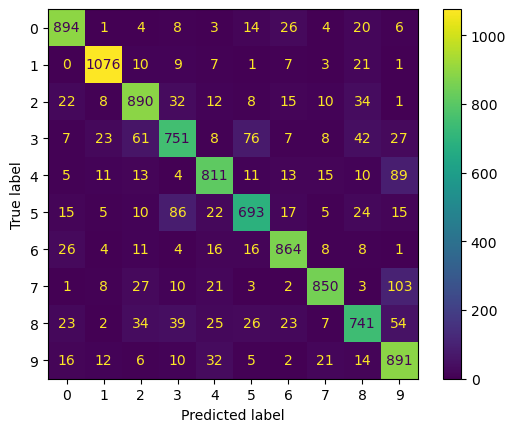

Отчёт классификации:


,precision,recall,f1-score,support
0,0.8860,0.9122,0.8989,980.0000
1,0.9357,0.9480,0.9418,1135.0000
2,0.8349,0.8624,0.8484,1032.0000
3,0.7880,0.7436,0.7652,1010.0000
4,0.8474,0.8259,0.8365,982.0000
5,0.8124,0.7769,0.7943,892.0000
6,0.8852,0.9019,0.8935,958.0000
7,0.9130,0.8268,0.8678,1028.0000
8,0.8081,0.7608,0.7837,974.0000
9,0.7500,0.8831,0.8111,1009.0000


In [39]:
## выведем матрицу ошибок и отчёт классификации

# classification_report
y_true = y_test
y_pred = np.array([x.argmax() for x in model.predict(X_test_resized)])

# матрица ошибок
print('\nМатрица ошибок классификации (на тестовой выборке):')
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()                             
plt.show()

# отчёт классификации

print('Отчёт классификации:')
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
pd.DataFrame(report).round(4).transpose()

Сравним качество обученной выше нейросети с показателями многоклассовой логистической регрессии, отчёт классификации также выведем и рассмотрим ниже.

#### Baseline Логистическая регрессия (многоклассовая) для предобработанных входных данных.

In [40]:
%%time
# создадим из наборов уменьшенных изображений набор данных для обучения логистич.регресси

train_data = pd.DataFrame(data=np.reshape(X_train_resized,(len(X_train_resized),-1,1))[...,0])
test_data = pd.DataFrame(data=np.reshape(X_test_resized,(len(X_test_resized),-1,1))[...,0])
print('Нормировнные значения яркости пикселей изображения в качестве признаков для обучения:')
display(train_data.sample(3))

# строим соотв. наборы признаков (обучение и тест) 
y_train_10cl = y_train
X_train_10cl = train_data.values

y_test_10cl = y_test
X_test_10cl = test_data.values

print('Размеры выборок для обученичения:')
print(*(X_train_10cl.shape, y_train_10cl.shape), (X_test_10cl.shape, y_test_10cl.shape), '\n')

Нормировнные значения яркости пикселей изображения в качестве признаков для обучения:


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
33140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.607844,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.966340,...,0.863399,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.914379,...,0.066013,0.045752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Размеры выборок для обученичения:
(60000, 36) (60000,) ((10000, 36), (10000,)) 

Wall time: 22.7 ms


In [41]:
%%time
# инициализация модели
model_LR10 = LogisticRegression(random_state=606, multi_class='multinomial')

# обучение модели с кросс-валидацией с подбором гиперпараметров по сетке (неподробно, близко к дефолтным)

## Pipeline с предобработкой не требуется, значения яркости уже нормированы
## выполним поиск лучших гиперпарметров по сетке с кросс-валидацией

grid = {
    'penalty': ['l2'], #['l1', 'l2'],
    'C': [105], #[*np.linspace(0.0001, 1, 50), *np.linspace(10, 100000, 50)],
    'max_iter': [5000],
    'class_weight': ['balanced'],
    'solver': ['saga']
}

LR10_clf = RandomizedSearchCV(
    model_LR,
    param_distributions=grid,
    random_state=606,
    n_iter=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    cv=4
)

LR10_clf.fit(X_train_10cl, y_train_10cl)

# выведем результаты на экран:
print('\nЛогистическая регрессия\n')
print('- Лучший accuracy_score = ', LR10_clf.best_score_.round(5))
print('- Лучшие параметры:\n\t', {str(i):LR10_clf.best_params_.get(i) for i in LR10_clf.best_params_})
print('- Лучшая модель:\n\t доступна из "LR_clf.best_estimator_"\n')

Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Morodze\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Логистическая регрессия

- Лучший accuracy_score =  0.7359
- Лучшие параметры:
	 {'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 105}
- Лучшая модель:
	 доступна из "LR_clf.best_estimator_"

Wall time: 14min 22s



Матрица ошибок классификации (на тестовой выборке):


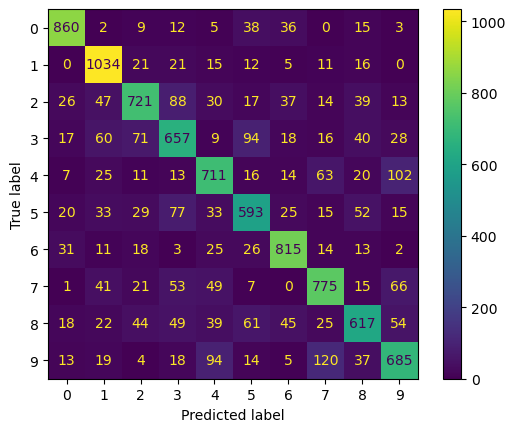

Отчёт классификации:


,precision,recall,f1-score,support
0,0.8661,0.8776,0.8718,980.0000
1,0.7991,0.9110,0.8514,1135.0000
2,0.7597,0.6986,0.7279,1032.0000
3,0.6630,0.6505,0.6567,1010.0000
4,0.7040,0.7240,0.7139,982.0000
5,0.6754,0.6648,0.6701,892.0000
6,0.8150,0.8507,0.8325,958.0000
7,0.7360,0.7539,0.7448,1028.0000
8,0.7141,0.6335,0.6714,974.0000
9,0.7076,0.6789,0.6930,1009.0000


In [42]:
## выведем матрицу ошибок и отчёт классификации

# classification_report
y_true = y_test_10cl
y_pred = LR10_clf.best_estimator_.predict(X_test_10cl)

# матрица ошибок
print('\nМатрица ошибок классификации (на тестовой выборке):')
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()                             
plt.show()

# отчёт классификации

print('Отчёт классификации:')
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
pd.DataFrame(report).round(4).transpose()

- Значения метрик качества модели (даже с настройками "по умолчанию" и без подбора гиперпараметров) получаются уже не столь однозначными как при сравнении работы классификаторов (нейросеть и логистич.регрессия) для 2 классов.


- Приведенные выше достижения многоклассовой логистич. регрессии получились ниже, чем метрики нейросетевой модели, а также затратилось значительно большее количество времени на обучение модели, подбор ГП и повторную подготовку признаков. Это снова поднимает вопрос о том, когда и какую модель целесообразнее использовать. Чаша весов всё же значительнее склоняется в пользу нейросетевого подхода в отношении избыточных данных (таких как изображения).


#### Нейросеть глубокого обучения (3 скрытых слоя + dropout) для НЕобработанных входных данных.

В конце концов сравним предыдущие модели (случай многоклассовой классификации) с результатами, которые может достигать более сложная нейросеть глубокого обучения с несколькими скрытыми слоями, но на данных без какой бы-то ни было предобработки. Будем подавать на вход сети изобраения из обучающей выборки без преобразования.  


Матрица ошибок классификации (на тестовой выборке):


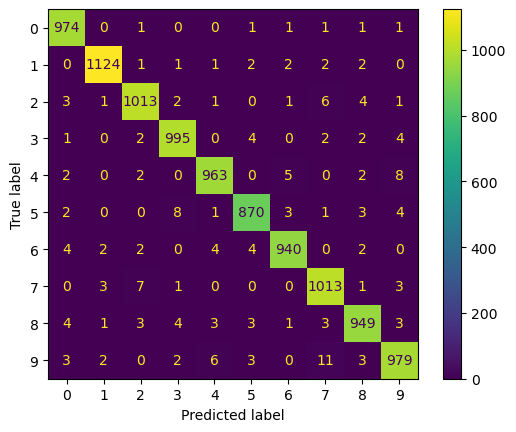

Отчёт классификации:


,precision,recall,f1-score,support
0,0.9809,0.9939,0.9873,980.000
1,0.9921,0.9903,0.9912,1135.000
2,0.9825,0.9816,0.9821,1032.000
3,0.9822,0.9851,0.9837,1010.000
4,0.9837,0.9807,0.9822,982.000
5,0.9808,0.9753,0.9781,892.000
6,0.9864,0.9812,0.9838,958.000
7,0.9750,0.9854,0.9802,1028.000
8,0.9794,0.9743,0.9768,974.000
9,0.9761,0.9703,0.9732,1009.000


In [43]:
# инициализируем новую модель и сконструируем новую сеть последовательным добавленеим слоёв
model = Sequential()

model.add(Flatten())                        ## начнём с плоского слоя
model.add(Dense(256, activation='relu'))    ## добавим несколько глубоких слоёв с разным кол-вом нейронов
model.add(Dropout(.3))                      ## и разными фукциями активации в них, а также слой с dropout-мех-ом  
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.001)       ## для инициализации вручную выберем оптимизатор с небольшим LR
                                            ## на этот раз снижать темп обучения ступенчато не станем
    
# инициализируем модель с нужной функцией потерь и выбранной метрикой кач-ва 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

# обучаем модель на тренировочных данных (без подготовки/сжатия, нормализации значений яркости произведена ранее)
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=64,
          #steps_per_epoch=1000,
          epochs=20,
          verbose=0,
          shuffle=True)

## выведем матрицу ошибок и отчёт классификации

# classification_report
y_true = y_test
y_pred = [x.argmax() for x in model.predict(X_test, verbose=0)]

# матрица ошибок
print('\nМатрица ошибок классификации (на тестовой выборке):')
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()                             
plt.show()

# отчёт классификации

print('Отчёт классификации:')
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
pd.DataFrame(report).round(4).transpose()

- Результат говорит сам за себя и чуть ли не кратно превосходит предыдущие модели. Вопреки ожиданиям обучение на изображениях 28х28 не вызвало роста сложности задачи на порядок, всё также доступно без использования GPU, архитектура получилась не слишком сложной и эффективной. Используем имеющуюся модель как итоговую.


### Альтернатива. Свёрточные сети.  

Слои свёртки и усреднения в своё время открыли новые пути в направлении совершенствования нейросетевых моделей. И явились своего рода вехой в развитии именно за счёт способностей таких слоёв "концентрировать" информацию из разреженного массива данных и учитывать взаимосвязи блоков информации (как водится в изображениях, звуке, текстах при присущей им избыточности). Такое дополнение к архитектуре со скрытыми слоями позволило искать новые пути для преобладания сетей на основе перцептронов над классическими алгоритмами машинного обучения в соотв. задачах.  


Будучи обученными на больших массивах данных, которые из-за присущих им ограничений просто "не переварят" классические ML-алгоритмы, такие сети должны успешно использоваться для задач классификации, сегметации и т.п. (в работе с регрессионными задачами есть своя специфика). Ниже приводится своеобразное воспроизведенеие архитектуры типа **LeNet** для решения задачи классификации на вышеуказанном примере:


    1. Подобная архитектура используется для классификации небольших изображений (20–30 пикселей в поперечнике), на вход модели будут приходить изображения в несжатом виде соотв. размера.

    2. Сеть начинается с 2-3 свёрточных слоёв размером 5x5, чередующихся со слоями пулинга *Average Pooling* размером 2x2. Эти слои постепенно уменьшают пространственное разрешение и концентрируют информацию в матрицы маленького размера.  

    3. Чтобы не потерять важную информацию, количество фильтров растёт от слоя к слою.  

    4. В конце сети идёт 1-2 полносвязных слоя, которые собирают все признаки и классифицируют их.

In [44]:
# для автоматизации подачи обучающих примеров в модель было решено применять на генераторы

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=64):
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return int(np.round(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        X = self.data[index * self.batch_size : (index+1) * self.batch_size]/255
        y = self.labels[index * self.batch_size : (index+1) * self.batch_size]

        return X, y

# для автоматизации подачи обучающих примеров в модель было решено применять на генераторы

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=64):
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return int(np.round(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        X = self.data[index * self.batch_size : (index+1) * self.batch_size]/255
        y = self.labels[index * self.batch_size : (index+1) * self.batch_size]

        return X, y

# подадим данные в генераторы  и сформируем обучающий и тестовый наборы данных
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_datagen = DataGenerator(X_train, y_train)
test_datagen = DataGenerator(X_test, y_test)

print(f'Кол-во батчей, сформированных из:\n'
      +f'\t- обучающей выборки ({X_train.shape[0]} изображений, по 64 объекта в батче): {len(train_datagen)} шт.'
      +f'\n\t- тестовой выборки ({X_test.shape[0]} изображений, по 64 объекта в батче): {len(test_datagen)} шт.')

print('\nХар-ки батчей:')
for X, y in train_datagen:
    print('\t- объекты внутри X:', X.shape)
    print('\t- классы объектов внутри y:', y.shape)
    break

Кол-во батчей, сформированных из:
	- обучающей выборки (60000 изображений, по 64 объекта в батче): 938 шт.
	- тестовой выборки (10000 изображений, по 64 объекта в батче): 156 шт.

Хар-ки батчей:
	- объекты внутри X: (64, 28, 28)
	- классы объектов внутри y: (64,)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 15)        2265      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 15)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 375)               0         
                                                                 
 dense_17 (Dense)            (None, 120)              

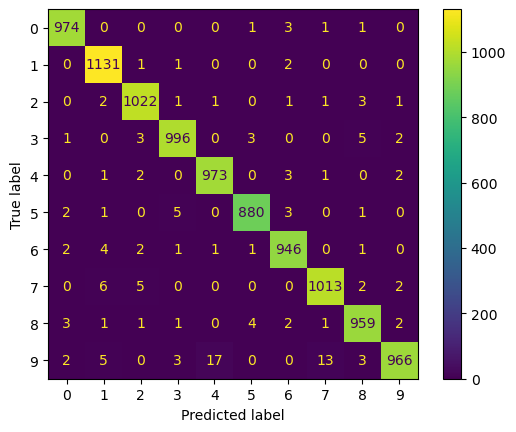

Отчёт классификации:
Wall time: 5min 10s


,precision,recall,f1-score,support
0,0.9898,0.9939,0.9919,980.000
1,0.9826,0.9965,0.9895,1135.000
2,0.9865,0.9903,0.9884,1032.000
3,0.9881,0.9861,0.9871,1010.000
4,0.9808,0.9908,0.9858,982.000
5,0.9899,0.9865,0.9882,892.000
6,0.9854,0.9875,0.9864,958.000
7,0.9835,0.9854,0.9845,1028.000
8,0.9836,0.9846,0.9841,974.000
9,0.9908,0.9574,0.9738,1009.000


In [45]:
%%time
# сконструируем и скомпилируем сверточную сеть для задачи:
tf.random.set_seed(606)

model = Sequential([
    
    #Conv2D_1:
    Conv2D(filters=6, kernel_size=(5,5), padding='same',
           input_shape=(28, 28, 1),
           activation='linear'),
    
    #avgpooling_1:
    AvgPool2D(pool_size=(2, 2), padding='same'),
    
    #Conv2D_2:
    Conv2D(filters=15, kernel_size=(5,5), padding='valid',
           activation='tanh'),
    
    #avgpooling_2:
    AvgPool2D(pool_size=(2, 2), padding='valid'),

    #flatten:
    Flatten(), #(input_shape=(*X_train.shape[1:], 1)),
    
    #dense layers:
    Dense(units=120, activation='relu'),
    #Dropout(.3),
    Dense(units=30, activation='sigmoid'),
    Dense(10, activation='softmax')   ## sigmoid заменяется на функцию softmax
])

## зададим learning_rate оптимизатора, отличный от стандартного, для более быстрого обучения
adam = Adam(learning_rate=0.001)

## для 10 классов используем категориальную кросс-энтропию
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# выведем информацию о модели и числе тренируемых параметров
model.summary()

## снова задаем EarlyStopping
early_stopping_pic = EarlyStopping(
    monitor="val_loss",          ## монитор, отслеживающий метрику на валидации 
    min_delta=0.0001,
    patience=20,                 ## задержка перед выходом из обучения по лучшему результату
    verbose=1,
    mode="auto",                 ## режим монитора (loss - должен падать, метрика - улучшаться)
    baseline=None,
    restore_best_weights=True,   ## модель должна восстанавливаться с лучшими весами
    start_from_epoch=10,
)

## снова задаем ReduceLROnPlateau
reduce_lr_pic = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.75,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.00001,
    cooldown=1,
    min_lr=1e-10
)

num_epochs = 50

model.fit(train_datagen,         ## генератор вместо (X_train, y_train)
          validation_data=test_datagen,
          epochs = num_epochs,           
          #batch_size=64,        ## не указыватеся, т.к. есть генератор
          #steps_per_epoch=100,  ## не указыватеся, т.к. есть генератор
          callbacks=[early_stopping_pic, reduce_lr_pic],   ## передаём callback
          shuffle=True,
          verbose=0)

## выведем матрицу ошибок и отчёт классификации

# classification_report
y_true = y_test
y_pred = [x.argmax() for x in model.predict(X_test)]

# матрица ошибок
print('\nМатрица ошибок классификации (на тестовой выборке):')
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()                             
plt.show()

# отчёт классификации

print('Отчёт классификации:')

report = classification_report(y_true, y_pred, digits=4, output_dict=True)
pd.DataFrame(report).round(4).transpose()

- Успех предыдущего классификатора успешно удалось превзойти, вдобавок нейросеть получилась "легче" предыддущей по количеству параметров, однако при этом становятся заметны ограничения датасета в плане сравнения качества разных классификаторов подобной (или лучшей) архитектуры. Видно, что дальнейшие изменения позволят ещё несколько нарастить показатели, но дабы не усложнять исследование данный этап станем считать завершенным.

### Выводы.

* Хотя углублённое изучение математических основ и программных реализаций нейросетей/перцептронов не выполнялось в силу временных и ресурсных ограничений (как со стороны автора так и со стороны учебной платформы 1Т), но всё-таки работа вышла за рамки задания. Удалось затронуть и проанализировать многие основополагающие понятия указанной области, работа получила новое "измерение" в виде синтеза этапов исследования и решения задачи.


* Полносвязные нейронные сети не могут "из коробки" успешно работать с большими изображениями: это ресурсоёмко и, если нейронов мало, сеть не найдёт зависимостей, а если много — c гарантией переобучится. Эта проблема решается свёрточными слоями, а также зарекомендовавшие себя с прошествием времени специализированные архитектурами нейронных сетей.


* Чтобы увеличить качество распознавания, кажется разумным использование следующих приёмов:   
    - простого увеличения качества изображений на входе (не такое сильное сжатие как 6х6),  
    - либо разумное использование несжатых изображений вкупе со свёрточными и пулинговыми слоями для уменьшения вычислительной нагрузки,
    - проведение операций аугментации для увеличния числа обучающих объектов.  
    
    
* Наконец автору удалось установить заметное преимущество перцепртронов глубокого обучения при сравнении с результатами работы классификаций, построенных на классических ML-алгоритмах. Превосходство в конце концов стало заметным благодаря обобшающей способности нейросетей, делающих их по истине универсальными классификаторами.

In [141]:
# небольшя проверка возможностей переноса вычислений на GPU\TPU
import torch
torch.has_mps, torch.cuda.is_available() ## на 'нет' и суда нет

(False, False)